# Read Data

In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('SUI_USDT_futures_15m_20241231.csv')

# Drop unused columns
df.drop(columns=['coin','unused', 'closetime'], inplace=True)

# Drop unused columns
df.drop(columns=['volume','quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote'], inplace=True)

# Display the first few rows of the DataFrame
df

,opentime,openprice,highprice,lowprice,closeprice
0,1683129600000,1.4030,1.4030,1.2652,1.3338
1,1683130500000,1.3339,1.3863,1.3327,1.3716
2,1683131400000,1.3717,1.3957,1.3547,1.3857
3,1683132300000,1.3866,1.3924,1.3652,1.3733
4,1683133200000,1.3731,1.3756,1.3405,1.3574
...,...,...,...,...,...
58323,1735620300000,4.0787,4.0850,4.0616,4.0828
58324,1735621200000,4.0829,4.0953,4.0738,4.0810
58325,1735622100000,4.0811,4.0990,4.0637,4.0982
58326,1735623000000,4.0982,4.1310,4.0900,4.1198


# Fecth Data

In [15]:
def binance_recursive_fetch_2(coins, interval, starttime, endtime=None, data_type='spot'):
    from time import sleep

    all_coins_result = {}
    data_list = []
    call_dict = {}

    for coin in tqdm(coins):
        result_list = []
        current_time = starttime
        call = 0

        while current_time < endtime if endtime else True:
            # Calculate the appropriate limit
            limit = 1000
            
            if data_type == 'spot':
                url = (f'https://api.binance.com/api/v3/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={current_time}'
                       f'&interval={interval}'
                       f'&limit={limit}')
            elif data_type == 'futures':
                url = (f'https://fapi.binance.com/fapi/v1/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={current_time}'
                       f'&interval={interval}'
                       f'&limit={limit}')

            response = requests.get(url)
            if response.status_code != 200:
                print(f"Error fetching data for {coin}: {response.status_code} - {response.text}")
                break

            data = response.json()
            if not data:
                print(f"No more data for {coin}. Ending fetch.")
                break

            # Filter out rows that exceed the endtime
            filtered_data = [row for row in data if row[0] < endtime] if endtime else data
            result_list += filtered_data
            
            if not filtered_data or filtered_data[-1][0] >= endtime:
                break

            # Update current_time for the next request
            current_time = filtered_data[-1][0] + 60000  # Move 1 minute ahead of the last returned timestamp
            call += 1

            # Avoid rate limiting
            sleep(0.1)

        current_df = pd.DataFrame(result_list, columns=BINANCE_CANDLE_COLUMNS)
        current_df['coin'] = coin
        current_df = current_df[['coin'] + BINANCE_CANDLE_COLUMNS]
        current_df = current_df.values.tolist()

        data_list += current_df
        call_dict[coin] = call

    return {'data': data_list, 'call': call_dict}

In [103]:

# Usage example
sample_spot = binance_recursive_fetch_2(
    ['XRP'],
    '5m',
    starttime=int(pd.to_datetime('2024-01-01 00:00', utc=True).timestamp() * 1000),
    endtime=int(pd.to_datetime('2024-12-31 23:59', utc=True).timestamp() * 1000),  # Specify endtime or set to None
    data_type='futures'
)

# Define the column names for the DataFrame based on the Binance API response structure
columns = ['coin', 'opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime', 
           'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

# Convert the list of data into a DataFrame
df = pd.DataFrame(sample_spot['data'], columns=columns)

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Convert columns 1-4 (openprice, highprice, lowprice, closeprice) to float
df[['openprice', 'highprice', 'lowprice', 'closeprice']] = df[['openprice', 'highprice', 'lowprice', 'closeprice']].apply(pd.to_numeric, errors='coerce')

# Show the first few rows of the DataFrame
df

100%|██████████| 1/1 [00:22<00:00, 22.58s/it]


,opentime,openprice,highprice,lowprice,closeprice
0,1704067200000,0.6157,0.6174,0.6152,0.6172
1,1704067500000,0.6171,0.6175,0.6167,0.6172
2,1704067800000,0.6172,0.6176,0.6168,0.6168
3,1704068100000,0.6169,0.6174,0.6164,0.6167
4,1704068400000,0.6167,0.6172,0.6159,0.6164
...,...,...,...,...,...
105403,1735688100000,2.0809,2.0810,2.0747,2.0760
105404,1735688400000,2.0761,2.0798,2.0757,2.0797
105405,1735688700000,2.0797,2.0834,2.0784,2.0827
105406,1735689000000,2.0826,2.0862,2.0823,2.0839


# Explore

In [104]:
df_setup = df.copy()

# Calculate candle body size
df_setup['body_size'] = abs(df_setup['closeprice'] - df_setup['openprice'])

# Calculate tail length
df_setup['high_tail'] = abs(df_setup['highprice'] - df_setup[['openprice', 'closeprice']].max(axis=1))
df_setup['low_tail'] = abs(df_setup['lowprice'] - df_setup[['openprice', 'closeprice']].min(axis=1))

# Calculate tail to body ratio
df_setup['high_tail_ratio'] = df_setup['high_tail'] / df_setup['body_size']
df_setup['low_tail_ratio'] = df_setup['low_tail'] / df_setup['body_size']

# Calculate body + tail
df_setup['body_high_tail_ratio'] = (df_setup['high_tail'] + df_setup['body_size']) / df_setup['openprice'] * 100
df_setup['body_low_tail_ratio'] = (df_setup['low_tail'] + df_setup['body_size']) / df_setup['openprice'] * 100

# Get next open price
df_setup['next_openprice'] = df_setup['openprice'].shift(-1)

df_setup

,opentime,openprice,highprice,lowprice,closeprice,body_size,high_tail,low_tail,high_tail_ratio,low_tail_ratio,body_high_tail_ratio,body_low_tail_ratio,next_openprice
0,1704067200000,0.6157,0.6174,0.6152,0.6172,0.0015,0.0002,0.0005,0.133333,0.333333,0.276108,0.324834,0.6171
1,1704067500000,0.6171,0.6175,0.6167,0.6172,0.0001,0.0003,0.0004,3.000000,4.000000,0.064819,0.081024,0.6172
2,1704067800000,0.6172,0.6176,0.6168,0.6168,0.0004,0.0004,0.0000,1.000000,0.000000,0.129618,0.064809,0.6169
3,1704068100000,0.6169,0.6174,0.6164,0.6167,0.0002,0.0005,0.0003,2.500000,1.500000,0.113471,0.081050,0.6167
4,1704068400000,0.6167,0.6172,0.6159,0.6164,0.0003,0.0005,0.0005,1.666667,1.666667,0.129723,0.129723,0.6165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105403,1735688100000,2.0809,2.0810,2.0747,2.0760,0.0049,0.0001,0.0013,0.020408,0.265306,0.240281,0.297948,2.0761
105404,1735688400000,2.0761,2.0798,2.0757,2.0797,0.0036,0.0001,0.0004,0.027778,0.111111,0.178219,0.192669,2.0797
105405,1735688700000,2.0797,2.0834,2.0784,2.0827,0.0030,0.0007,0.0013,0.233333,0.433333,0.177910,0.206761,2.0826
105406,1735689000000,2.0826,2.0862,2.0823,2.0839,0.0013,0.0023,0.0003,1.769231,0.230769,0.172861,0.076827,2.0840


In [117]:
import pandas as pd
import numpy as np

# Initialize parameters for iteration
tr_ratios = [1,2,3,4,5]
bt_ratios = [0.5,0.75,1,1.25,1.5]
maker_fee = 0.05  # Maker fee for the trades
results = []  # To store the results

# Outer loop for tr_ratio
for tr_ratio in tr_ratios:
    for bt_ratio in bt_ratios:
        # Add a new column 'next_trend' and set default value to 0
        df_setup['next_trend'] = 0
        df_setup.loc[(df_setup['high_tail_ratio'] >= tr_ratio) & 
                     (df_setup['low_tail_ratio'] < tr_ratio) & 
                     (df_setup['body_high_tail_ratio'] >= bt_ratio), 'next_trend'] = -1
        df_setup.loc[(df_setup['low_tail_ratio'] >= tr_ratio) & 
                     (df_setup['high_tail_ratio'] < tr_ratio) & 
                     (df_setup['body_low_tail_ratio'] >= bt_ratio), 'next_trend'] = 1

        df_setup.dropna(inplace=True)

        # Initialize variables for trend alternation
        indices = []
        previous_trend = None
        previous_index = None

        for idx, row in df_setup.iterrows():
            current_trend = row['next_trend']

            if previous_trend is None:
                if current_trend in [1, -1]:
                    previous_trend = current_trend
                    previous_index = idx
            else:
                if previous_trend == 1 and current_trend == -1:
                    indices.append((previous_trend, previous_index, current_trend, idx))
                    previous_trend = -1
                    previous_index = idx
                elif previous_trend == -1 and current_trend == 1:
                    indices.append((previous_trend, previous_index, current_trend, idx))
                    previous_trend = 1
                    previous_index = idx

        result_df = pd.DataFrame(indices, columns=['Start_Trend', 'Start_Index', 'End_Trend', 'End_Index'])

        filtered_df_setup = df_setup.loc[result_df['Start_Index']]
        filtered_df_setup.reset_index(drop=True, inplace=True)

        # Backtest DataFrame
        df_backtest = filtered_df_setup.copy()
        df_backtest['pnl'] = (df_backtest['next_openprice'] - df_backtest['next_openprice'].shift(1)) / df_backtest['next_openprice'].shift(1) * 100
        df_backtest['pnl'] = np.where(df_backtest['next_trend'] == 1, df_backtest['pnl'] * -1, df_backtest['pnl'])

        # Calculate cumulative PnL over time
        df_backtest['cumulative_pnl'] = df_backtest['pnl'].cumsum()

        # Calculate the sum of PnL
        total_pnl = df_backtest['pnl'].sum()

        # Count the rows in df_backtest
        row_count = len(df_backtest)

        total_rows_in_setup = len(df_setup)

        # Calculate win rate
        wins = df_backtest.apply(lambda row: 1 if ((row['pnl'] > 0 and row['next_trend'] == -1) or (row['pnl'] < 0 and row['next_trend'] == 1)) else 0, axis=1)
        win_rate = wins.sum() / row_count * 100 if row_count > 0 else 0

        net_pnl_sum = total_pnl - row_count * maker_fee * 2

        backtest_to_setup_ratio = row_count / total_rows_in_setup * 100 if total_rows_in_setup > 0 else 0

        score = net_pnl_sum * backtest_to_setup_ratio

        results.append({'tr_ratio': tr_ratio, 'bt_ratio': bt_ratio, 'pnl_sum': total_pnl, 'row_count': row_count, 
                        'win_rate': win_rate, 'net_pnl_sum': net_pnl_sum, 'backtest_to_setup_ratio': backtest_to_setup_ratio, 'score': score})

        # Display cumulative PnL for this backtest
        print(df_backtest[['next_openprice', 'pnl', 'cumulative_pnl']])

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

      next_openprice        pnl  cumulative_pnl
0             0.6307        NaN             NaN
1             0.6304  -0.047566       -0.047566
2             0.6260   0.697970        0.650403
3             0.5534 -11.597444      -10.947041
4             0.5500   0.614384      -10.332657
...              ...        ...             ...
1446          2.0364   3.143876      192.073712
1447          2.0239  -0.613828      191.459884
1448          2.0788  -2.712585      188.747299
1449          2.0509  -1.342120      187.405179
1450          2.1173  -3.237603      184.167576

[1451 rows x 3 columns]
     next_openprice        pnl  cumulative_pnl
0            0.6359        NaN             NaN
1            0.6189   2.673376        2.673376
2            0.5534 -10.583293       -7.909917
3            0.5500   0.614384       -7.295533
4            0.5750   4.545455       -2.750078
..              ...        ...             ...
599          2.2231  -2.366809      181.377449
600          2.2211  -0

,tr_ratio,bt_ratio,pnl_sum,row_count,win_rate,net_pnl_sum,backtest_to_setup_ratio,score
0,1,0.50,184.167576,1451,50.103377,39.067576,1.382603,54.014934
1,1,0.75,182.179574,604,51.821192,121.779574,0.575529,70.087628
2,1,1.00,33.513003,264,53.787879,7.113003,0.251556,1.789315
3,1,1.25,-14.054104,143,51.748252,-28.354104,0.136259,-3.863509
4,1,1.50,4.482447,72,52.777778,-2.717553,0.068606,-0.186441
5,2,0.50,78.587199,719,52.573018,6.687199,0.685108,4.581452
6,2,0.75,-22.970923,263,51.711027,-49.270923,0.250603,-12.347425
7,2,1.00,19.919909,125,53.600000,7.419909,0.119108,0.883769
8,2,1.25,-139.750008,65,56.923077,-146.250008,0.061936,-9.058144
9,2,1.50,97.463726,41,60.975610,93.363726,0.039067,3.647472


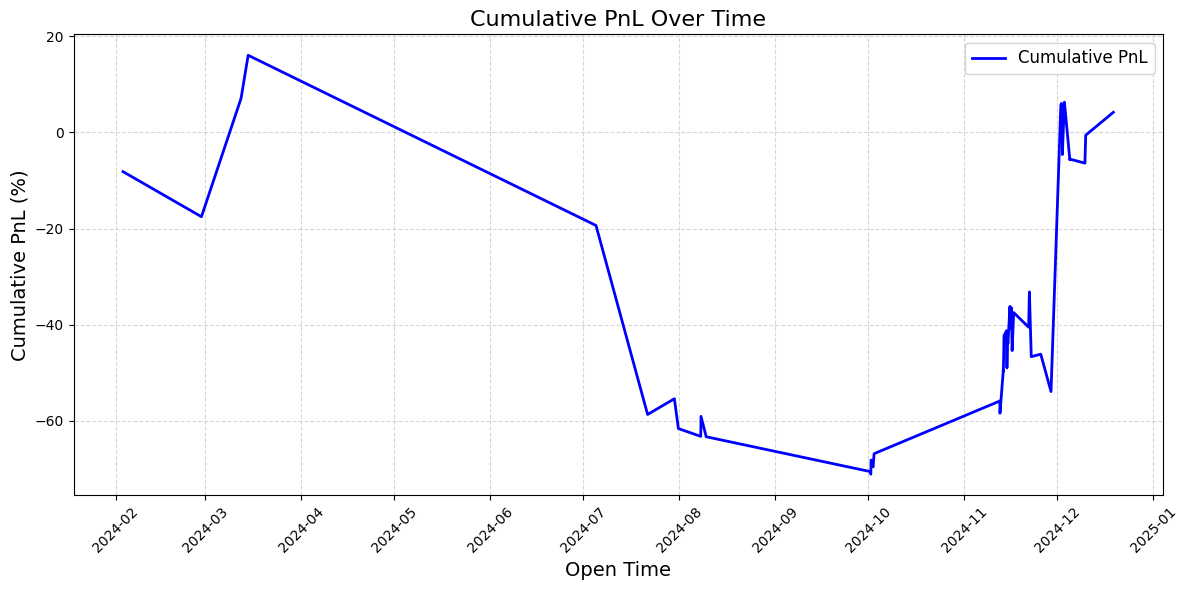

In [116]:
import matplotlib.pyplot as plt

# Convert opentime from milliseconds to a readable date format
df_backtest['opentime'] = pd.to_datetime(df_backtest['opentime'], unit='ms')

# Plot the cumulative PnL vs opentime
plt.figure(figsize=(12, 6))
plt.plot(df_backtest['opentime'], df_backtest['cumulative_pnl'], label='Cumulative PnL', color='blue', linewidth=2)
plt.title('Cumulative PnL Over Time', fontsize=16)
plt.xlabel('Open Time', fontsize=14)
plt.ylabel('Cumulative PnL (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()